# PREPOZNAVANJE AUTOMOBILA

Ucitavanje biblioteka.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 
import os
from skimage.feature import hog

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn import metrics

Ucitavanje skupa podataka. Imamo dva foldera - jedan u kom se nalaze automobili, dok se u drugom ne nalaze.

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

cars_far = load_images_from_folder('data\car\GTI_Far')
cars_left = load_images_from_folder('data\car\GTI_Left') 
cars_middle = load_images_from_folder('data\car\GTI_MiddleClose') 
cars_right = load_images_from_folder('data\car\GTI_Right') 
cars_kitti = load_images_from_folder('data\car\KITTI_extracted')
cars = cars_far + cars_left + cars_middle + cars_right + cars_kitti
no_cars = load_images_from_folder('data\\no car')

In [4]:
len(cars)

8786

In [5]:
len(no_cars)

7991

Pikazacemo jednu sliku automobila. Primecujemo da slika ima tri kanala jer se radio o RGB slici. 

(64, 64, 3)


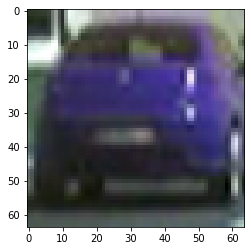

In [6]:
image = cars[267]
print(image.shape)

plt.imshow(image)
plt.show()

Prebacujemo sliku u monohromatsku.

(64, 64)


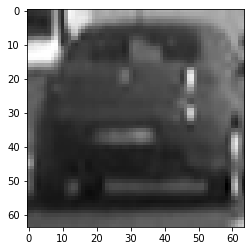

In [7]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image_gray.shape)

plt.imshow(image_gray, cmap = 'gray')
plt.show()

## Prepoznavanje objekta koriscenjem HOG (Histogram Orijentisanih Gradijenata)


Kako bismo napravili HOG deskriptor, moramo izracunati odgovarajuce horizontalne i vertikalne gradijente da bismo dobili histogram koji se kasnije moze koristiti u algoritmu. <br /> Magnituda i smer se mogu jednostavno naci koriscenjem sledecih formula
            $$ m = \sqrt{{q_x}^2 + {q_y}^2}  $$
            $$ \theta = \arctan{q_y \over q_x}  $$
Da bismo presli na sledeci korak HOG algoritma, slika treba da je podeljena u celije kako bi se histogram gradijenata mogao izracunati za svaku celiju. Na primer, ako imamo sliku velicine 64 x 128, treba da podelimo sliku u celije velicine 8 x 8. Dalje, celija 8 x 8 moze se jednostavno objasniti koriscenjem 128 brojeva (8x8x2 gde su poslednja cifra objasnjava magnitudu i smer). <br /> Histogram cemo podeliti u devet stubica sirine 20, gde su vrednosti uglova od 0–180. 

U paketu feature biblioteke skimage nalaze se funkcije za koriscenje HOG metode.

In [8]:
features, hog_image = hog(image_gray, 
                          orientations = 11, # broj orijentacija
                          pixels_per_cell = (16, 16), # dimenzije celije
                          cells_per_block = (2, 2), 
                          transform_sqrt = False, 
                          visualize = True, 
                          feature_vector = True)
features.shape 

(396,)

In [9]:
hog_image.shape

(64, 64)

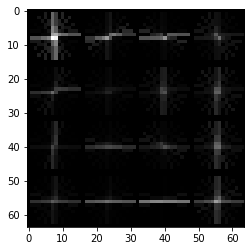

In [10]:
plt.imshow(hog_image, cmap='gray')
plt.show()

(180,)


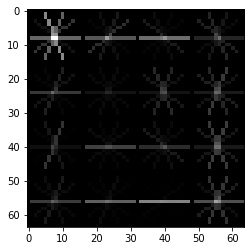

In [11]:
features, hog_image = hog(image_gray, 
                          orientations = 5, # broj orijentacija
                          pixels_per_cell = (16, 16), # dimenzije celije
                          cells_per_block = (2, 2), 
                          transform_sqrt = False, 
                          visualize = True, 
                          feature_vector = True)
print(features.shape) 
plt.imshow(hog_image, cmap='gray')
plt.show()

(1764,)


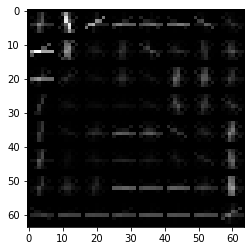

In [12]:
features, hog_image = hog(image_gray, 
                          orientations = 9, # broj orijentacija
                          pixels_per_cell = (8, 8), # dimenzije celije
                          cells_per_block = (2, 2), 
                          transform_sqrt = False, 
                          visualize = True, 
                          feature_vector = True)
print(features.shape)  
plt.imshow(hog_image, cmap='gray')
plt.show()

(44,)


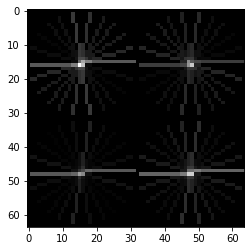

In [13]:
features, hog_image = hog(image_gray, 
                          orientations = 11, # broj orijentacija
                          pixels_per_cell = (32, 32), # dimenzije celije
                          cells_per_block = (2, 2), 
                          transform_sqrt = False, 
                          visualize = True, 
                          feature_vector = True)
print(features.shape)  
plt.imshow(hog_image, cmap='gray')
plt.show()

(324,)


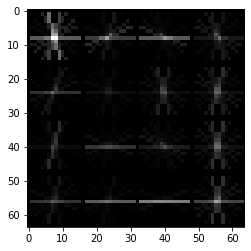

In [14]:
features, hog_image = hog(image_gray, 
                          orientations = 9, # broj orijentacija
                          pixels_per_cell = (16, 16), # dimenzije celije
                          cells_per_block = (2, 2), 
                          transform_sqrt = False, 
                          visualize = True, 
                          feature_vector = True)
print(features.shape) 
plt.imshow(hog_image, cmap='gray')
plt.show()

Primetimo da sa smanjenjem broja piksela po celiji, histogram orijentisanih gradijenata poprima karakteristican oblik automobila, dok pri vecim vrednostima tog parametra histogram izgleda apstraktnije i neodredjenije. Analogno tome, ukoliko povecavamo broj orijentacija mozemo videti kako usmereni gradijenti bolje prate ivice automobila. <br /> Velicina vektora je obrnuto proporcionalna broju piksela po celiji i broju celija po bloku, a proporcionalna broju orijentacija. S obzirom na to da velicina vektora moze drasticno uticati na performanse, potrebno je naci optimalnu kombinaciju velcine vektora i brzine izvodjenja.

### Priprema skupa za testiranje

Primenicemo prethodne metode na ceo car i no car skup podataka.

In [15]:
cars_hog = []

for car in cars:
    image_color = car
    image_gray  = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    car_hog_feature, car_hog_img = hog(image_gray, 
                                    orientations = 11, 
                                    pixels_per_cell = (16, 16), 
                                    cells_per_block = (2, 2), 
                                    transform_sqrt = False, 
                                    visualize = True, 
                                    feature_vector = True)
                
    cars_hog.append(car_hog_feature)

In [16]:
X_cars = np.vstack(cars_hog).astype(np.float64)  
y_cars = np.ones(len(X_cars)) # 1 oznacava pristustvo automobila

In [17]:
X_cars.shape

(8786, 396)

In [18]:
y_cars.shape

(8786,)

In [19]:
nocars_hog = []

for no_car in no_cars:
    image_color = no_car
    image_gray  = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    nocar_hog_feature, car_hog_img = hog(image_gray, 
                                    orientations = 11, 
                                    pixels_per_cell = (16, 16), 
                                    cells_per_block = (2, 2), 
                                    transform_sqrt = False, 
                                    visualize = True, 
                                    feature_vector = True)
                
    nocars_hog.append(nocar_hog_feature)

In [20]:
X_nocars = np.vstack(nocars_hog).astype(np.float64)  
y_nocars = np.zeros(len(X_nocars)) # 0 znaci da nema automobila na slici

In [21]:
X_nocars.shape

(7991, 396)

In [22]:
y_nocars.shape

(7991,)

Skup podataka - atributi i ciljna promenljiva

In [23]:
X = np.vstack((X_cars, X_nocars))
X.shape

(16777, 396)

In [24]:
y = np.hstack((y_cars, y_nocars))
y.shape

(16777,)

## Treniranje SVM modela i njegova evaluacija 

Podatke cemo pripremiti podelom na skup za treniranje i skup za testiranje u razmeri 3:1. Vrednost random_state parametra cemo postaviti nasumicno na 101.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101, stratify=y)

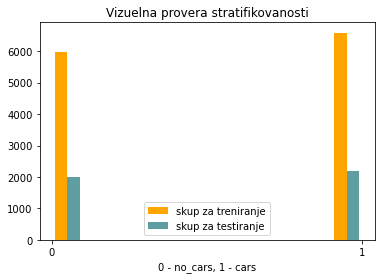

In [26]:
plt.title('Vizuelna provera stratifikovanosti')
plt.xticks([0,1])
plt.xlabel('0 - no_cars, 1 - cars')
plt.hist([y_train, y_test], color=['orange', 'cadetblue'], label=['skup za treniranje', 'skup za testiranje'])
plt.legend(loc='best')
plt.show()

Model cemo kreirati pozivom funkcije svm.LinearSVC() i dalje trenirati pozivom funkcije fit nad skupom za treniranje.

In [27]:
model = svm.LinearSVC()
model.fit(X_train, y_train)

LinearSVC()

In [28]:
y_pred = model.predict(X_test)

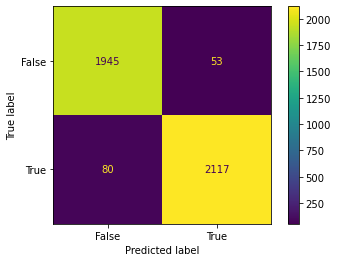

In [29]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()
plt.show()

Organizacija ove matrice je sledeća:

   - na poziciji (0, 0) se nalazi TN vrednost,
   - na poziciji (1, 0) FN vrednost,
   - na poziciji (1, 1) je TP vrednost,
   - i konačno, na poziciji (0, 1) je FP vrednost.

In [30]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      1998
         1.0       0.98      0.96      0.97      2197

    accuracy                           0.97      4195
   macro avg       0.97      0.97      0.97      4195
weighted avg       0.97      0.97      0.97      4195



Prikazacemo prvih 50 predvidjenih i tacnih vrednosti ciljne promenljive.

In [31]:
model_pred = model.predict(X_test[0:50])
model_pred

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.])

In [32]:
y_test[0:50]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.])

## Popravka modela - izbor optimalnih vrednosti hiperparametra

Hiperparametri kernelizovanog SVM modela koje cemo podešavati su C i gamma. Oni, redom, kontrolisu jacinu regularizacije i sirinu (engl. bandwidth) RBF kernela.

In [33]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']} 

grid = GridSearchCV(svm.SVC(), param_grid, scoring='accuracy', cv=5, return_train_score=True, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='accuracy', verbose=1)

Ocitavamo najbolji rezultat i njemu pridruzene parametre.

In [36]:
grid.best_score_

0.9907805618140049

In [34]:
grid.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

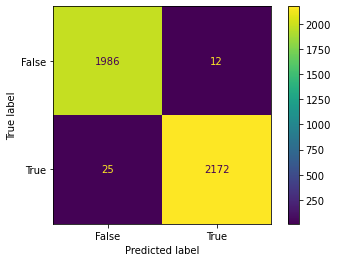

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1998
         1.0       0.99      0.99      0.99      2197

    accuracy                           0.99      4195
   macro avg       0.99      0.99      0.99      4195
weighted avg       0.99      0.99      0.99      4195



In [35]:
y_grid_pred = grid.predict(X_test)
cm_grid = metrics.confusion_matrix(y_test, y_grid_pred)
cm = metrics.confusion_matrix(y_test, y_grid_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()
plt.show()
print(metrics.classification_report(y_test, y_grid_pred))

Mozemo jos testirati kako se nas model ponasa za novu sliku.

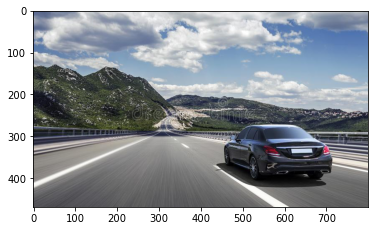

In [37]:
test_image = cv2.imread('test_image.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
plt.show()

(140, 800, 3)

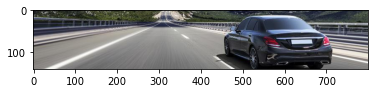

In [38]:
# oblast od interesa
h_start = 260 
h_stop = 400

# definisemo vrednosti HOG parametra
pixels_in_cell = 16 
cells_in_step = 3 

# iseci cemo deo slike gde se nalaze automobili
masked_region = test_image[h_start:h_stop,:,:]
plt.imshow(masked_region)
masked_region.shape

(70, 400, 3)


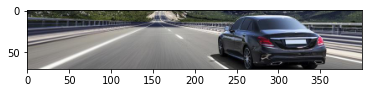

In [39]:
# smanjujemo velicinu slike
resizing_factor = 2
masked_region_shape = masked_region.shape
duzina = masked_region_shape[1]/resizing_factor
sirina = masked_region_shape[0]/resizing_factor
masked_region_resized = cv2.resize(masked_region, (np.int(duzina), np.int(sirina)))

print(masked_region_resized.shape)
plt.imshow(masked_region_resized)
plt.show()

In [40]:
# prebacujemo sliku u monohromatsku
masked_region_resized_gray = cv2.cvtColor(masked_region_resized, cv2.COLOR_RGB2GRAY)
print(masked_region_resized_gray.shape)    
# primenjujemo HOG
masked_region_hog_feature_all, hog_img = hog(masked_region_resized_gray, 
                                             orientations = 11, 
                                             pixels_per_cell = (16, 16), 
                                             cells_per_block = (2, 2), 
                                             transform_sqrt = False, 
                                             visualize = True, 
                                             feature_vector = False)

(70, 400)


In [41]:
# na osnovu nase slike mozemo da zakljucimo da je optimalni broj koraka koji treba da imamo 8 (steps_x)
# dok cemo ih traziti samo u jednom redu (steps_y) posto smo vec izdvojili deo slike u kom ih trazimo
# napomena: koraci su za nasu test sliku, treba ih prilagoditi za neku drugu sliku - priblizno 1/50 duzine slike bi bilo steps_x,
# a ako se automobili nalaze u vise redova prilagoditi i steps_y
steps_x = 8
steps_y = 1
blocks_in_window = 3

rectangle_found = [] # lista u kojoj cuvamo nadjene automobile, tj. pravougaonike u kojima se nalaze automobili

for xb in range(steps_x):
    for yb in range(steps_y):
        
        y_position = yb*cells_in_step
        x_position = xb*cells_in_step
        hog_sample = masked_region_hog_feature_all[y_position : (y_position + blocks_in_window),
                                                        x_position : (x_position + blocks_in_window)].ravel() 
        test_predicted = grid.predict(hog_sample.reshape(1,-1))
        
        x_left = x_position * pixels_in_cell
        y_top = y_position * pixels_in_cell
               
        if test_predicted == 1: # model je predvideo da se nalazi automobil na izdvojenoj slici
            # izvlacimo dimenzije, tj. pravougaonik u kom se nalazi automobil (tako da odgovaraju originalnoj slici)
            rectangle_x_left = np.int(x_left * resizing_factor)
            rectangle_y_top = np.int(y_top * resizing_factor)
            window_dim = np.int(64 * resizing_factor)
            rectangle_found.append(((rectangle_x_left, rectangle_y_top + h_start),
                               (rectangle_x_left + window_dim, rectangle_y_top + window_dim + h_start)))            

In [42]:
rectangle_found

[((576, 260), (704, 388))]

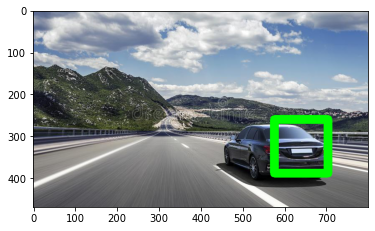

In [43]:
# prikazujemo nadjene automobile
Image_with_Rectangles = np.copy(test_image)
    
for rectangle in rectangle_found:
    cv2.rectangle(Image_with_Rectangles, rectangle[0], rectangle[1], (0, 255, 0), 20)

plt.imshow(Image_with_Rectangles)
plt.show()  